In [1]:
from __future__ import absolute_import, division, print_function
import os, sys

In [2]:
BASEDIR = os.path.abspath(os.path.curdir)
print(BASEDIR)

/home/zhoutao/Documents/PythonDataScienceHandbook/notebooks/06_Natural_Language/gameofthrones2vec


In [4]:
import codecs
import glob
import logging
import multiprocessing
import os
import pprint
import re

In [8]:
import nltk
import gensim.models.word2vec as w2v
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

Using TensorFlow backend.


In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


日志

In [5]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [4]:
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /home/zhoutao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/zhoutao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
book_filenames = sorted(glob.glob(BASEDIR + "/data/*.txt"))

In [6]:
book_filenames

['/home/zhoutao/Documents/PythonDataScienceHandbook/notebooks/06_Natural_Language/gameofthrones2vec/data/got1.txt',
 '/home/zhoutao/Documents/PythonDataScienceHandbook/notebooks/06_Natural_Language/gameofthrones2vec/data/got2.txt',
 '/home/zhoutao/Documents/PythonDataScienceHandbook/notebooks/06_Natural_Language/gameofthrones2vec/data/got3.txt',
 '/home/zhoutao/Documents/PythonDataScienceHandbook/notebooks/06_Natural_Language/gameofthrones2vec/data/got4.txt',
 '/home/zhoutao/Documents/PythonDataScienceHandbook/notebooks/06_Natural_Language/gameofthrones2vec/data/got5.txt']

In [7]:
corpus_raw = u""
for book_filename in book_filenames:
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, "r", "utf-8") as book_file:
        corpus_raw += book_file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw)))
    print()

Reading '/home/zhoutao/Documents/PythonDataScienceHandbook/notebooks/06_Natural_Language/gameofthrones2vec/data/got1.txt'...
Corpus is now 1770659 characters long

Reading '/home/zhoutao/Documents/PythonDataScienceHandbook/notebooks/06_Natural_Language/gameofthrones2vec/data/got2.txt'...
Corpus is now 4071041 characters long

Reading '/home/zhoutao/Documents/PythonDataScienceHandbook/notebooks/06_Natural_Language/gameofthrones2vec/data/got3.txt'...
Corpus is now 6391405 characters long

Reading '/home/zhoutao/Documents/PythonDataScienceHandbook/notebooks/06_Natural_Language/gameofthrones2vec/data/got4.txt'...
Corpus is now 8107945 characters long

Reading '/home/zhoutao/Documents/PythonDataScienceHandbook/notebooks/06_Natural_Language/gameofthrones2vec/data/got5.txt'...
Corpus is now 9719485 characters long



In [9]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

### 将文章分割成句子

In [10]:
raw_sentences = tokenizer.tokenize(corpus_raw)

In [14]:
raw_sentences

[u'This edition contains the complete text of the original hardcover edition.',
 u'NOT ONE WORD HAS BEEN OMITTED.',
 u'A CLASH OF KINGS\n\nA Bantam Spectra Book\n\nPUBLISHING HISTORY\n\nBantam Spectra hardcover edition published February 1999\n\nBantam Spectra paperback edition / September 2000\n\nSPECTRA and the portrayal of a boxed \u201cs\u201d are trademarks of Bantam Books, a division of Random House, Inc.\n\nAll rights reserved.',
 u'Copyright \xa9 1999 by George R. R. Martin.',
 u'Maps by James Sinclair.',
 u'Heraldic crest by Virginia Norey.',
 u'Library of Congress Catalog Card Number: 98-37954.',
 u'No part of this book may be reproduced or transmitted in any form or by any means, electronic or mechanical, including photocopying, recording, or by any information storage and retrieval system, without permission in writing from the publisher.',
 u'Visit our website at www.bantamdell.com\n\nBantam Books, the rooster colophon, Spectra and the portrayal of a boxed \u201cs\u201d ar

### 通过正则表达式保留字母,并且分割单词

In [11]:
#convert into a list of words
#rtemove unnnecessary,, split into words, no hyphens
#list of words
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words

In [12]:
#sentence where each word is tokenized
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [15]:
sentences[:2]  # 每个小List是一个句子

[[u'This',
  u'edition',
  u'contains',
  u'the',
  u'complete',
  u'text',
  u'of',
  u'the',
  u'original',
  u'hardcover',
  u'edition'],
 [u'NOT', u'ONE', u'WORD', u'HAS', u'BEEN', u'OMITTED']]

In [13]:
print(raw_sentences[5])
print(sentence_to_wordlist(raw_sentences[5]))

Heraldic crest by Virginia Norey.
[u'Heraldic', u'crest', u'by', u'Virginia', u'Norey']


In [15]:
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 1,818,103 tokens


# 2 用word2vec训练词向量

In [16]:
# 1 参数 

num_features = 300
# Minimum word count threshold.
min_word_count = 3

# Number of threads to run in parallel.
#more workers, faster we train
num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 7

# Downsample setting for frequent words.
#0 - 1e-5 is good for this
downsampling = 1e-3

# Seed for the RNG, to make the results reproducible.
#random number generator
#deterministic, good for debugging
seed = 1

In [17]:
# 2 模型
thrones2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [18]:
thrones2vec.build_vocab(sentences)

#### 2.1查看字典库

In [19]:
print("Word2Vec vocabulary length:", len(thrones2vec.wv.vocab))

Word2Vec vocabulary length: 17277


#### 2.2训练单词，成为词向量

In [21]:
thrones2vec.train(sentences)

2017-06-11 19:15:31,390 : INFO : training model with 4 workers on 17277 vocabulary and 300 features, using sg=1 hs=0 sample=0.001 negative=5 window=7
2017-06-11 19:15:31,390 : INFO : expecting 128868 sentences, matching count from corpus used for vocabulary survey
2017-06-11 19:15:32,394 : INFO : PROGRESS: at 4.64% examples, 322887 words/s, in_qsize 8, out_qsize 0
2017-06-11 19:15:33,400 : INFO : PROGRESS: at 10.08% examples, 345888 words/s, in_qsize 8, out_qsize 0
2017-06-11 19:15:34,405 : INFO : PROGRESS: at 15.25% examples, 350883 words/s, in_qsize 8, out_qsize 0
2017-06-11 19:15:35,410 : INFO : PROGRESS: at 20.21% examples, 352961 words/s, in_qsize 8, out_qsize 0
2017-06-11 19:15:36,437 : INFO : PROGRESS: at 25.52% examples, 354611 words/s, in_qsize 8, out_qsize 0
2017-06-11 19:15:37,450 : INFO : PROGRESS: at 31.02% examples, 357786 words/s, in_qsize 8, out_qsize 0
2017-06-11 19:15:38,476 : INFO : PROGRESS: at 36.56% examples, 359290 words/s, in_qsize 8, out_qsize 0
2017-06-11 19:1

7021557

In [20]:
if not os.path.exists("trained"):
    os.makedirs("trained")

#### 2.3 保存词向量模型

In [21]:
thrones2vec.save(os.path.join("trained", "thrones2vec.w2v"))

#### 2.4 加载词向量模型

In [24]:
thrones2vec = w2v.Word2Vec.load(os.path.join("trained", "thrones2vec.w2v"))

2017-06-11 19:21:17,102 : INFO : loading Word2Vec object from trained/thrones2vec.w2v
2017-06-11 19:21:17,201 : INFO : loading wv recursively from trained/thrones2vec.w2v.wv.* with mmap=None
2017-06-11 19:21:17,201 : INFO : setting ignored attribute syn0norm to None
2017-06-11 19:21:17,202 : INFO : setting ignored attribute cum_table to None
2017-06-11 19:21:17,202 : INFO : loaded trained/thrones2vec.w2v


# 3 TSNE 模型
http://www.datakit.cn/blog/2017/02/05/t_sne_full.html

t-SNE(t-distributed stochastic neighbor embedding)是用于降维的一种机器学习算法。 t-SNE 是一种非线性降维算法，非常适用于高维数据降维到2维或者3维，进行可视化。

1.1基本原理

SNE是通过仿射(affinitie)变换将数据点映射到概率分布上，主要包括两个步骤：

    SNE构建一个高维对象之间的概率分布，使得相似的对象有更高的概率被选择，而不相似的对象有较低的概率被选择。
    SNE在低维空间里在构建这些点的概率分布，使得这两个概率分布之间尽可能的相似。

我们看到t-SNE模型是非监督的降维，他跟kmeans等不同，他不能通过训练得到一些东西之后再用于其它数据（比如kmeans可以通过训练得到k个点，再用于其它数据集，而t-SNE只能单独的对数据做操作，也就是说他只有fit_transform，而没有fit操作）

In [22]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [23]:
all_word_vectors_matrix = thrones2vec.wv.syn0  # 字典词向量矩阵

In [24]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)  # 将词向量降到2维

In [26]:
all_word_vectors_matrix_2d.shape

(17277, 2)

In [31]:
thrones2vec.wv.vocab

TypeError: 'collections.defaultdict' object is not callable

In [32]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[thrones2vec.wv.vocab[word].index])
            for word in thrones2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [33]:
points.head(10)

,word,x,y
0,fawn,-0.506240,-0.017621
1,raining,0.169951,1.043999
2,writings,-0.194849,0.486901
3,Ysilla,-0.500234,0.856678
4,realms,1.188194,0.171704
5,hordes,1.654438,-1.378648
6,mustachio,1.011493,-0.254167
7,Greyjoy,0.772763,-0.846972
8,both,-0.098843,-0.420773
9,yellow,-0.110059,0.568381


In [34]:
sns.set_context("poster")

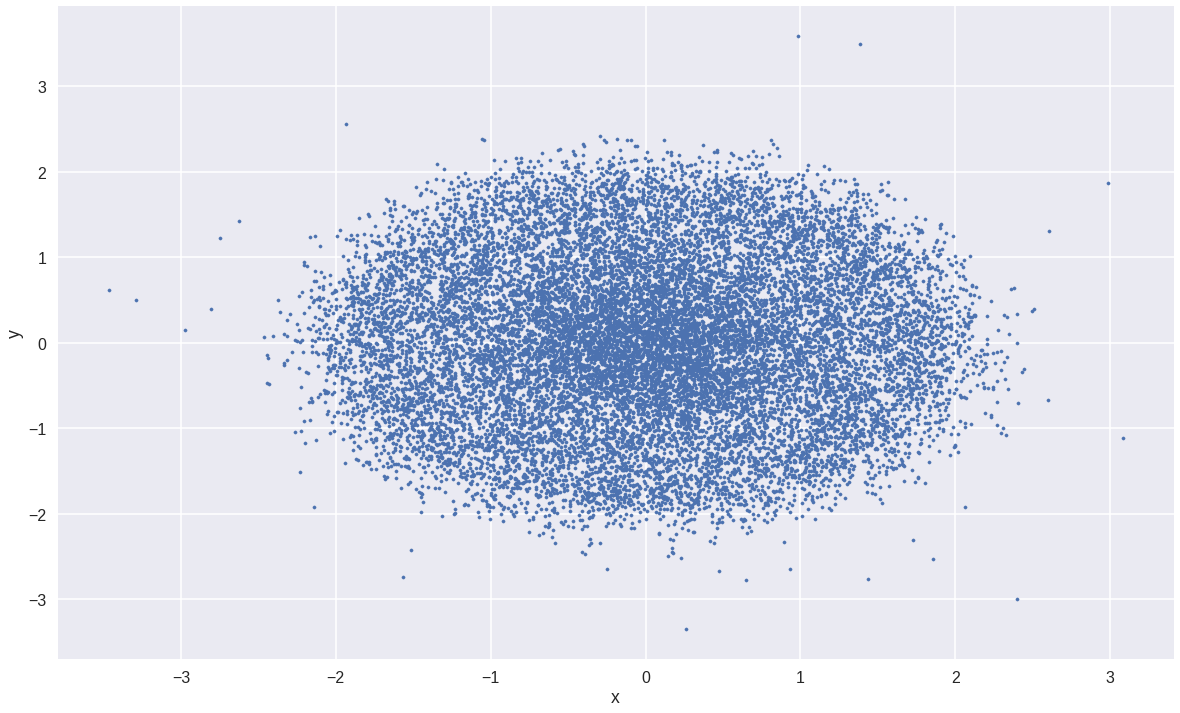

In [37]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))
plt.show()

#### 3.1 单词降维之后在平面上的分布

In [38]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

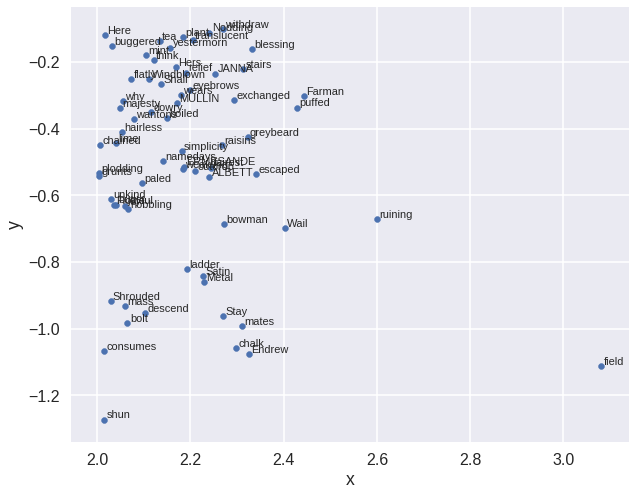

In [45]:
# plot_region(x_bounds=(4.0, 4.2), y_bounds=(-1.5, -0.1))
plot_region(x_bounds=(2.0, 4.2), y_bounds=(-1.5, -0.1))
plt.show()

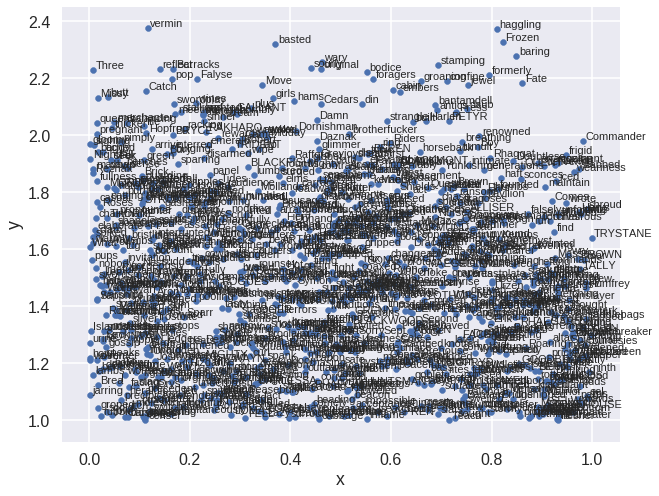

In [48]:
plot_region(x_bounds=(0, 1), y_bounds=(1, 2.5))
plt.show()

#### 3.2 单词的相似度

In [40]:
thrones2vec.wv.most_similar("Stark")

[(u'Eddard', 0.7325112819671631),
 (u'Winterfell', 0.6618878841400146),
 (u'Lyanna', 0.6476459503173828),
 (u'Rickard', 0.6393085718154907),
 (u'Karstark', 0.6334391832351685),
 (u'Robb', 0.6296013593673706),
 (u'executed', 0.6248215436935425),
 (u'beheaded', 0.614325225353241),
 (u'Tully', 0.6094435453414917),
 (u'Benjen', 0.607344925403595)]

In [41]:
thrones2vec.most_similar("Aerys")

[(u'Jaehaerys', 0.7924706339836121),
 (u'Mad', 0.7878335118293762),
 (u'Daeron', 0.7578268051147461),
 (u'reign', 0.7421121597290039),
 (u'rebellion', 0.7358454465866089),
 (u'Cruel', 0.7231711149215698),
 (u'Conciliator', 0.7206258773803711),
 (u'Rhaegar', 0.7180657982826233),
 (u'II', 0.7164472341537476),
 (u'Since', 0.7097236514091492)]

In [42]:
thrones2vec.most_similar("direwolf")

[(u'wolf', 0.678396999835968),
 (u'Rickon', 0.6777439117431641),
 (u'SHAGGYDOG', 0.6517823934555054),
 (u'Ghost', 0.6450621485710144),
 (u'Reed', 0.6368789672851562),
 (u'Robb', 0.6254981756210327),
 (u'OSHA', 0.611676037311554),
 (u'pup', 0.6109311580657959),
 (u'Shaggydog', 0.6054069995880127),
 (u'GHOST', 0.5984951853752136)]

#### 3.3 单词的正负样本

In [43]:
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = thrones2vec.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [44]:
nearest_similarity_cosmul("Stark", "Winterfell", "Riverrun")
nearest_similarity_cosmul("Jaime", "sword", "wine")
nearest_similarity_cosmul("Arya", "Nymeria", "dragons")

Stark is related to Winterfell, as Tully is related to Riverrun
Jaime is related to sword, as drank is related to wine
Arya is related to Nymeria, as Dany is related to dragons


u'Dany'